In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Jitter

In [240]:
def io_file(path):
    with open(path, "r") as file:
        a = file.read().split('\n')
        result = []
        temp = {}

        for row in a:
            if 'Iter' in row:
                result.append(temp)
                temp = {}
                temp['Iter'] = int(re.findall(r'\d+', row)[0])
            elif 'SW-SCHE' in row:
                temp['SW-SCHE'] = row.split(' ')[-1]
            elif 'SW-SEND' in row:
                temp['SW-SEND'] = row.split(' ')[-1]
            elif 'HW-SEND' in row:
                temp['HW-SEND'] = row.split(' ')[-1].split('.')[-1]

        format_result = np.zeros((result[-1]['Iter'] + 1, 3))

        for maps in result:
            if 'Iter' in maps:
                index = int(maps['Iter'])
                if 'SW-SCHE' in maps:
                    format_result[index, 0] = np.float64(maps['SW-SCHE'])
                else:
                    format_result[index, 0] = np.nan
                if 'SW-SEND' in maps:
                    format_result[index, 1] = np.float64(maps['SW-SEND'])
                else:
                    format_result[index, 1] = np.nan
                if 'HW-SEND' in maps:
                    format_result[index, 2] = np.int64(maps['HW-SEND'])
                else:
                    format_result[index, 2] = np.nan
        return format_result

In [320]:
dell_result = io_file('dell_50us.txt')
dell_result = io_file('dell_50us.txt')

In [321]:
np.sum(np.isnan(dell_result), axis = 0)

array([      0, 1334134, 1334134])

In [322]:
dell_result.shape[0]

1999992

In [323]:
dell_result.shape[0]

153507

In [324]:
np.sum(np.isnan(dell_result), axis = 0) / cm4_result.shape[0]

array([0.        , 0.99999349, 0.99999349])

In [325]:
np.sum(np.isnan(dell_result), axis = 0) / dell_result.shape[0]

array([0.        , 0.66706967, 0.66706967])

In [332]:
np.nanmin(np.diff(dell_result[:, 1]))

4.0531158447265625e-06

In [333]:
np.nanmax(np.diff(dell_result[:, 1]))

0.0024611949920654297

In [334]:
dell_sw = 5e-6 - np.diff(dell_result[:, 1])
cm4_sw = 5e-6 - np.diff(cm4_result[:, 1])
dell_hw = np.diff(dell_result[:, 2] % 5e7) * 1e-9
cm4_hw = np.diff(cm4_result[:, 2] % 5e7) * 1e-9

In [335]:
print(
    np.nanmean(np.abs(dell_sw)), 
        np.nanmean(np.abs(cm4_sw)), 
        np.nanmean(np.abs(dell_hw)), 
        np.nanmean(np.abs(cm4_hw))
     )

0.00015556016188401434 nan 0.00015032092307692307 nan


/tmp/ipykernel_172726/516289474.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.abs(cm4_sw)),
/tmp/ipykernel_172726/516289474.py:5: RuntimeWarning: Mean of empty slice
  np.nanmean(np.abs(cm4_hw))


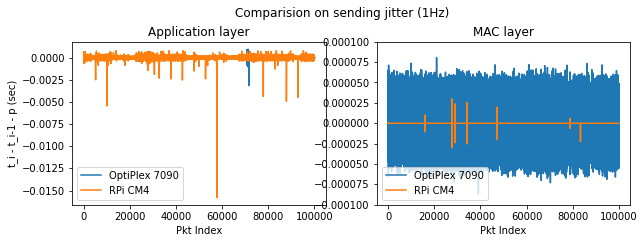

In [319]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))

ax = sns.lineplot(ax=axes[0], x=range(dell_sw.shape[0]), y = dell_sw, label='OptiPlex 7090')
ax = sns.lineplot(ax=axes[0], x=range(cm4_sw.shape[0]), y = cm4_sw, label='RPi CM4')
ax.set_xlabel('Pkt Index')
ax.set_ylabel('t_i - t_i-1 - p (sec)')
ax.set_title('Application layer')

ax = sns.lineplot(ax=axes[1],x=range(dell_hw.shape[0]), y = dell_hw, label='OptiPlex 7090')
ax = sns.lineplot(ax=axes[1],x=range(cm4_hw.shape[0]), y = cm4_hw, label='RPi CM4')
ax.set_xlabel('Pkt Index')
ax.set_title('MAC layer')
ax.set_ylim(-1e-4, 1e-4)

fig.suptitle('Comparision on sending jitter (1Hz)', va='bottom')
fig.savefig('100hz_jitter.pdf', bbox_inches='tight')

## Synchronization

In [46]:
cm4_result_offset = []
cm4_result_delay = []
with open("cm4_phy2sys_sync.txt", "r") as file:
    a = file.read().split('\n')
    for row in a:
        stat = re.findall(r' -*\d+', row)
        offset = eval(stat[0])
        delay = eval(stat[1])
        cm4_result_offset.append(offset)
        cm4_result_delay.append(delay)

In [47]:
dell_result_offset = []
dell_result_delay = []
with open("dell_phy2sys_sync.txt", "r") as file:
    a = file.read().split('\n')
    for row in a:
        stat = re.findall(r' -*\d+', row)
        offset = eval(stat[0])
        delay = eval(stat[2])
        dell_result_offset.append(offset)
        dell_result_delay.append(delay)

In [48]:
dell_result_offset = dell_result_offset[2:]
cm4_result_offset = cm4_result_offset[2:]

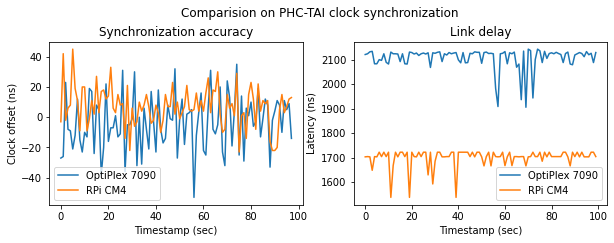

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))

ax = sns.lineplot(ax=axes[0], x=range(len(dell_result_offset)), y = dell_result_offset, label='OptiPlex 7090')
ax = sns.lineplot(ax=axes[0], x=range(len(cm4_result_offset)), y = cm4_result_offset, label='RPi CM4')
ax.set_xlabel('Timestamp (sec)')
ax.set_ylabel('Clock offset (ns)')
ax.set_title('Synchronization accuracy')

ax = sns.lineplot(ax=axes[1],x=range(len(dell_result_delay)), y = dell_result_delay, label='OptiPlex 7090')
ax = sns.lineplot(ax=axes[1],x=range(len(cm4_result_delay)), y = cm4_result_delay, label='RPi CM4')
ax.set_xlabel('Timestamp (sec)')
ax.set_ylabel('Latency (ns)')
ax.set_title('Link delay')

fig.suptitle('Comparision on PHC-TAI clock synchronization', va='bottom')
fig.savefig('sync_local.pdf', bbox_inches='tight')

In [56]:
cm4_result_offset = []
cm4_result_delay = []
with open("cm4_ptp4l_sync.txt", "r") as file:
    a = file.read().split('\n')
    for row in a:
        stat = re.findall(r' \d+ ', row)
        offset = eval(stat[0])
        delay = eval(stat[-1])
        cm4_result_offset.append(offset)
        cm4_result_delay.append(delay)

In [58]:
dell_result_offset = []
dell_result_delay = []
with open("dell_ptp4l_sync.txt", "r") as file:
    a = file.read().split('\n')
    for row in a:
        stat = re.findall(r' \d+ ', row)
        offset = eval(stat[0])
        delay = eval(stat[-1])
        dell_result_offset.append(offset)
        dell_result_delay.append(delay)

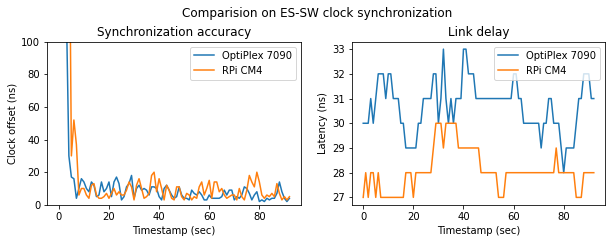

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))

ax = sns.lineplot(ax=axes[0], x=range(len(dell_result_offset)), y = dell_result_offset, label='OptiPlex 7090')
ax = sns.lineplot(ax=axes[0], x=range(len(cm4_result_offset)), y = cm4_result_offset, label='RPi CM4')
ax.set_xlabel('Timestamp (sec)')
ax.set_ylabel('Clock offset (ns)')
ax.set_ylim(0, 100)
ax.set_title('Synchronization accuracy')

ax = sns.lineplot(ax=axes[1],x=range(len(dell_result_delay)), y = dell_result_delay, label='OptiPlex 7090')
ax = sns.lineplot(ax=axes[1],x=range(len(cm4_result_delay)), y = cm4_result_delay, label='RPi CM4')
ax.set_xlabel('Timestamp (sec)')
ax.set_ylabel('Latency (ns)')
ax.set_title('Link delay')

fig.suptitle('Comparision on ES-SW clock synchronization', va='bottom')
fig.savefig('sync_utral.pdf', bbox_inches='tight')